In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


from timeit import default_timer
from Solver import *
from functools import partial

import torch

import sys
sys.path.append('../Utility')
from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
import NeuralNet
import PlotDefault



In [8]:
beta_rek_strs = [("1", "0p3"), ("2", "0p3"), ("3", "0p3"), ("1", "0p6"), ("2", "0p6"), ("3", "0p6")]

#beta_rek_strs = [("1", "0p3"), ]


beta_reks = [ (str_to_num(beta_rek_strs[i][0]), str_to_num(beta_rek_strs[i][1])) for i in range(len(beta_rek_strs)) ]
physics_params, q_mean, psi_mean, dpv_mean,  mu_mean, mu_mean_clip,  closure_mean, yy, force = load_data(beta_rek_strs = beta_rek_strs, beta_reks = beta_reks)

# Visualize data

Text(0.5, 0.98, 'bottom layer')

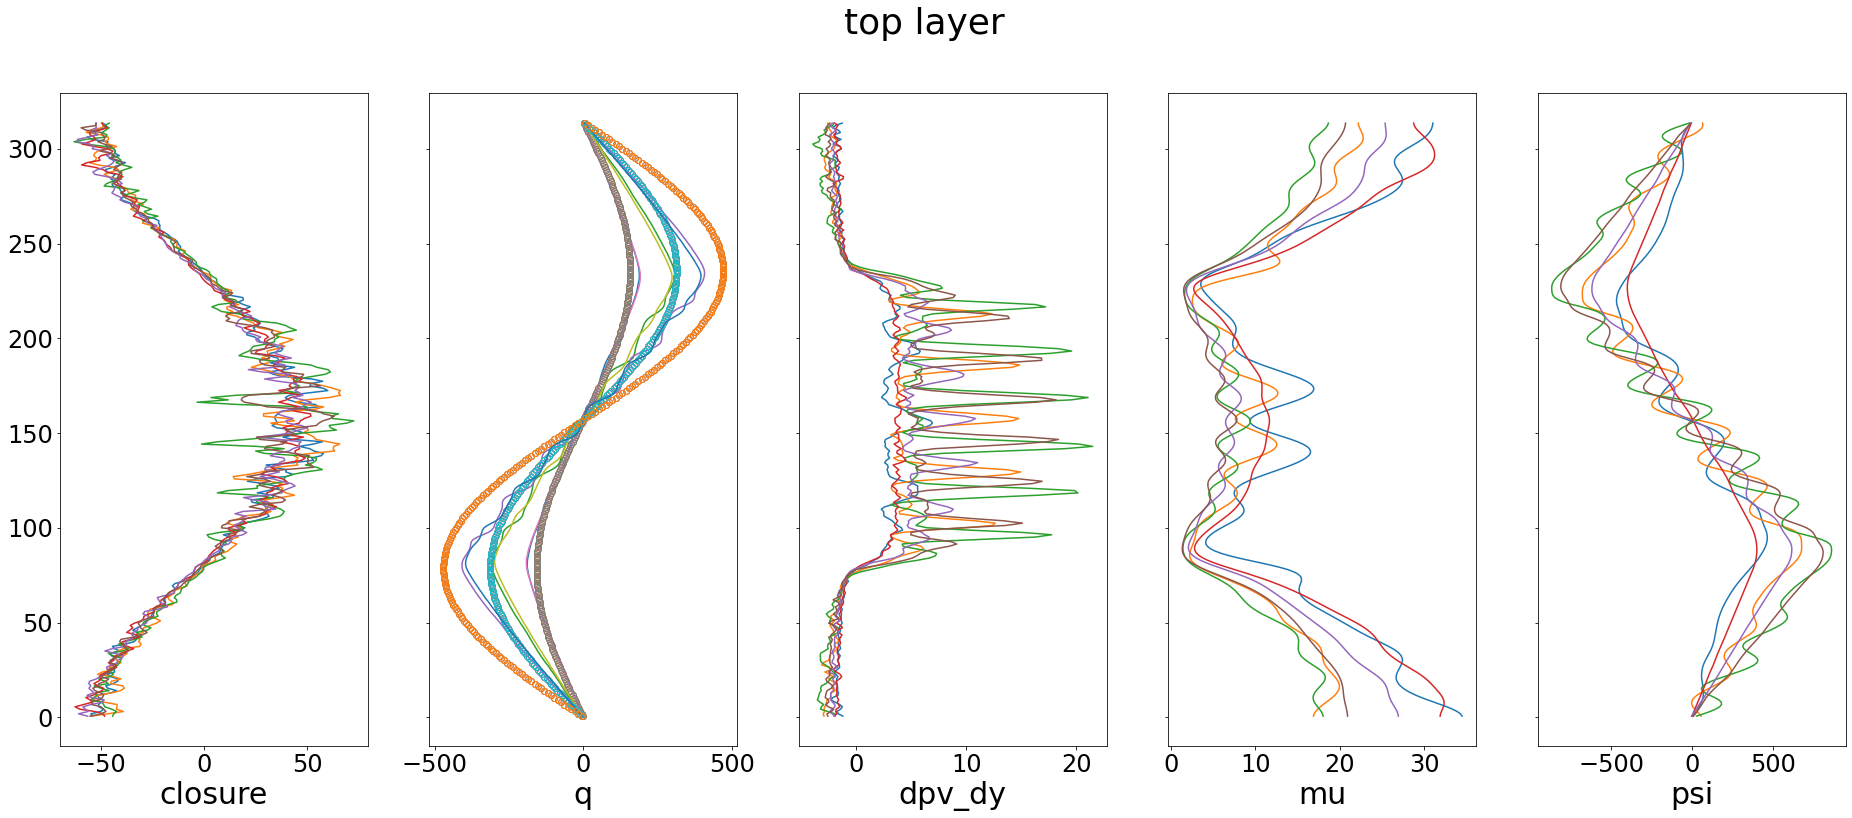

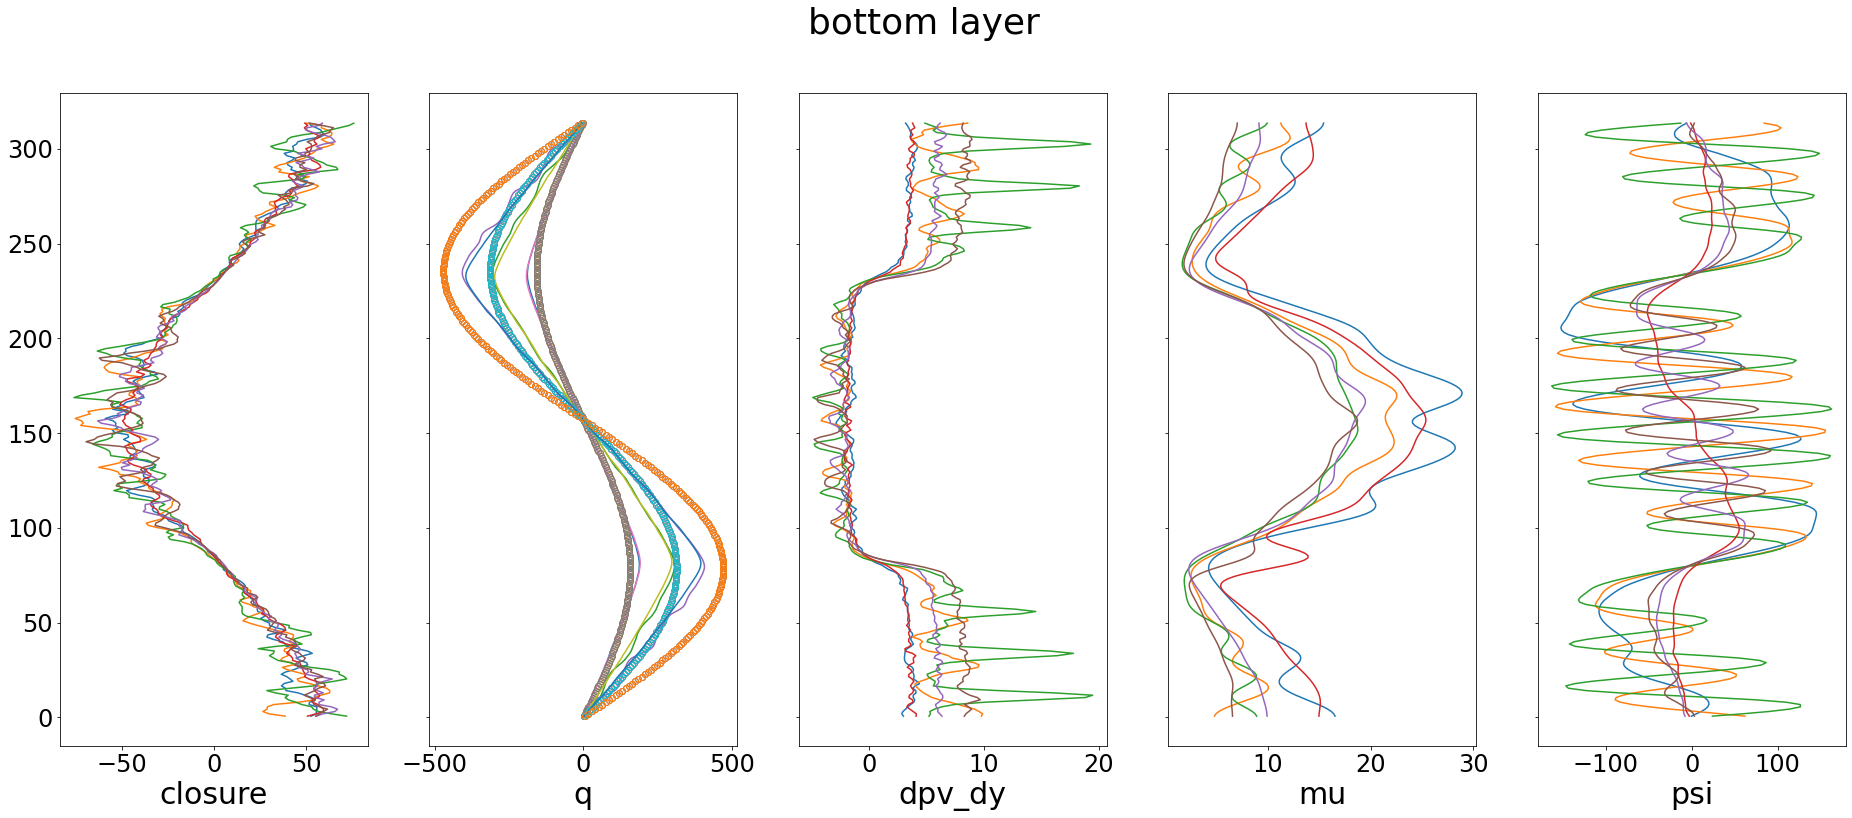

In [9]:
L = 50.0 *2*np.pi

N_data = len(beta_reks)
layer = 0
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
    
    ax[1].plot(-beta_reks[i][0]*L/2*np.sin(2*np.pi*yy/L), yy, "o", fillstyle="none")
    
    
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean_clip[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("top layer")

layer = 1
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
               
    ax[1].plot(beta_reks[i][0]*L/2*np.sin(2*np.pi*yy/L), yy, "o", fillstyle="none")
                          
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean_clip[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("bottom layer")

# scatter training points

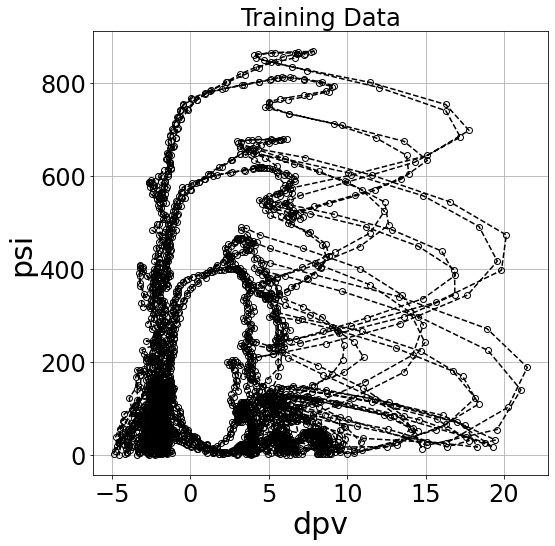

In [10]:
plt.figure(figsize=(8,8))
for i in range(N_data):
#     plt.plot(np.fabs(q_mean[i,0,:]), dpv_mean[i, 0, :],  "--o", color = "black", fillstyle="none")
#     plt.plot(np.fabs(q_mean[i,1,:]), dpv_mean[i, 1, :],  "--o", color = "black", fillstyle="none")
    plt.plot(dpv_mean[i, 0, :], np.fabs(psi_mean[i,0,:]),   "--o", color = "black", fillstyle="none")
    plt.plot(dpv_mean[i, 1, :], np.fabs(psi_mean[i,1,:]),  "--o", color = "black", fillstyle="none")
    
plt.grid("on")
plt.xlabel("dpv")
plt.ylabel("psi")
plt.title("Training Data")

    
plt.subplots_adjust(bottom=0.15,top=0.92,left=0.18,right=0.97)
plt.savefig("QG-Training-Data.pdf")

In [11]:
# scale input 
for nn_save_name in ["diffusivity.nn", "flux.nn"]:
    # np.fabs(q_mean).flatten()/q_scale,
    x_train = torch.from_numpy(np.stack((np.fabs(q_mean).flatten()/q_scale, dpv_mean.flatten()/dpv_scale, np.fabs(psi_mean).flatten()/psi_scale)).T.astype(np.float32)) 
    if nn_save_name == "diffusivity.nn":
        outputlayer = "sigmoid"
        y_train = (torch.from_numpy(mu_mean_clip.flatten()[:,np.newaxis].astype(np.float32)) - mu_low) / mu_scale
    elif nn_save_name == "flux.nn":
        outputlayer = "tanh"
        y_train = torch.from_numpy(closure_mean.flatten()[:,np.newaxis].astype(np.float32)) / flux_scale
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
        
    ind = x_train.shape[1]
    outd = y_train.shape[1] 

    learning_rate = 0.001
    step_size = 100
    gamma = 0.5  
    epochs = 20000
    batch_size = 64


    net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = torch.nn.MSELoss(reduction='sum')
    t0 = default_timer()
    for ep in range(epochs):
        net.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:

            optimizer.zero_grad()
            out = net(x)

            loss = myloss(out , y)*100
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

    #     scheduler.step()

        if ep % 100 == 0:
            # train_l2/= ntrain
            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
            if nn_save_name is not None:
                torch.save(net, nn_save_name)



/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  0  Epoch time :  0.048504894599318504  Train L2 Loss :  28730.713134765625
Epoch :  100  Epoch time :  0.04864760860800743  Train L2 Loss :  291.9692192077637
Epoch :  200  Epoch time :  0.04590899311006069  Train L2 Loss :  235.3810031414032
Epoch :  300  Epoch time :  0.03683251701295376  Train L2 Loss :  170.00647127628326
Epoch :  400  Epoch time :  0.03996463865041733  Train L2 Loss :  134.5312534570694
Epoch :  500  Epoch time :  0.038590842857956886  Train L2 Loss :  116.31877160072327
Epoch :  600  Epoch time :  0.04867814853787422  Train L2 Loss :  107.20507895946503
Epoch :  700  Epoch time :  0.0480956956744194  Train L2 Loss :  103.59216749668121
Epoch :  800  Epoch time :  0.043875813484191895  Train L2 Loss :  102.19474840164185
Epoch :  900  Epoch time :  0.05430434085428715  Train L2 Loss :  100.66021543741226
Epoch :  1000  Epoch time :  0.03816867247223854  Train L2 Loss :  100.18992626667023
Epoch :  1100  Epoch time :  0.04679500497877598  Train L2 Loss :  

/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch :  0  Epoch time :  0.04937129281461239  Train L2 Loss :  52303.834228515625
Epoch :  100  Epoch time :  0.03882012888789177  Train L2 Loss :  2740.3184185028076
Epoch :  200  Epoch time :  0.039364783093333244  Train L2 Loss :  2048.2499446868896
Epoch :  300  Epoch time :  0.05148368328809738  Train L2 Loss :  1834.5352249145508
Epoch :  400  Epoch time :  0.060574157163500786  Train L2 Loss :  1743.5976848602295
Epoch :  500  Epoch time :  0.062176018953323364  Train L2 Loss :  1675.7859363555908
Epoch :  600  Epoch time :  0.05951504409313202  Train L2 Loss :  1639.0775871276855
Epoch :  700  Epoch time :  0.05942784063518047  Train L2 Loss :  1607.2903480529785
Epoch :  800  Epoch time :  0.061754483729600906  Train L2 Loss :  1584.2170391082764
Epoch :  900  Epoch time :  0.06055687740445137  Train L2 Loss :  1565.676528930664
Epoch :  1000  Epoch time :  0.05981047451496124  Train L2 Loss :  1544.5763607025146
Epoch :  1100  Epoch time :  0.060284968465566635  Train L2 Los

# Direct test

../Utility/NeuralNet.py:508: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()
../Utility/NeuralNet.py:508: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()
/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


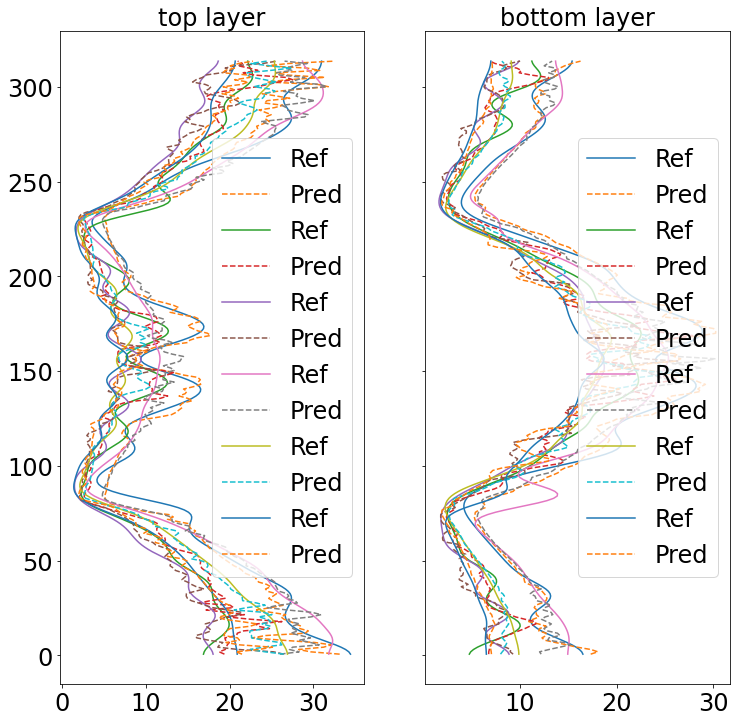

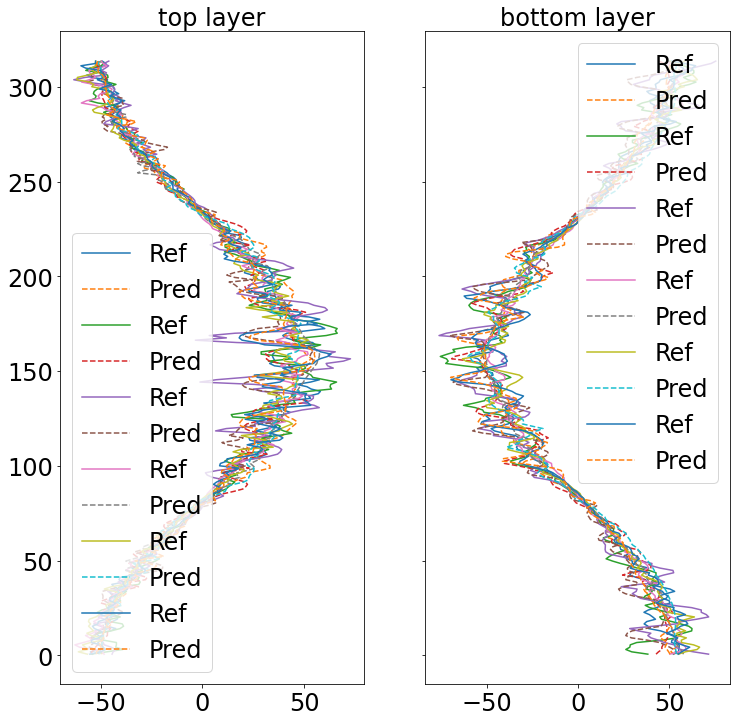

In [12]:
L = 50.0 *2*np.pi

N_data = len(beta_reks)
layer = 0

for nn_save_name in ["diffusivity.nn", "flux.nn"]:
    trained_net = torch.load(nn_save_name)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(12,12))
    x_train = torch.from_numpy(np.stack((np.fabs(q_mean).flatten()/q_scale, dpv_mean.flatten()/dpv_scale, np.fabs(psi_mean).flatten()/psi_scale)).T.astype(np.float32)) 
    
    if nn_save_name == "diffusivity.nn":
        outputlayer = "sigmoid"
        y_pred = NeuralNet.net_eval(net=trained_net, x=x_train, mu_scale=mu_scale, non_negative=False, filter_on=False, filter_sigma=filter_sigma, n_data=2*N_data) + mu_low 
        y_pred = y_pred.reshape((N_data, 2, len(yy)))
        for i in range(N_data):
            ax[0].plot(mu_mean_clip[i,0, :], yy, label="Ref")
            ax[1].plot(mu_mean_clip[i,1, :], yy, label="Ref")
            ax[0].plot(y_pred[i,0, :], yy, "--", label="Pred")
            ax[1].plot(y_pred[i,1, :], yy, "--",label="Pred")
        
            
    elif nn_save_name == "flux.nn":
        outputlayer = "tanh"
        y_pred = NeuralNet.net_eval(net=trained_net, x=x_train, mu_scale=flux_scale, non_negative=False, filter_on=False, filter_sigma=filter_sigma, n_data=2*N_data) 
        y_pred = y_pred.reshape((N_data, 2, len(yy)))
        for i in range(N_data):
            ax[0].plot(closure_mean[i,0, :], yy, label="Ref")
            ax[1].plot(closure_mean[i,1, :], yy, label="Ref")
            ax[0].plot(y_pred[i,0, :], yy, "--", label="Pred")
            ax[1].plot(y_pred[i,1, :], yy, "--", label="Pred")
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
    ax[0].legend()
    ax[0].set_title("top layer")
    ax[1].legend()
    ax[1].set_title("bottom layer")
  

# Plug-in Test

/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


200000 max q 243.69197909804453
400000 max q 256.3360662684779


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


200000 max q 834.7166712951599
400000 max q 1071.907147874181


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


200000 max q 336.73109649981495
400000 max q 333.0595524672013


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


200000 max q 980.1738625159896
400000 max q 1049.0028024799617


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


200000 max q 432.11038560722
400000 max q 385.7498551694311


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


200000 max q 870.2911475448464
400000 max q 1136.5929889816352


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


200000 max q 199.30934396050972
400000 max q 203.4103170232432


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


200000 max q 684.3620517368956
400000 max q 885.7411759440015


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


200000 max q 330.1534169485309
400000 max q 324.8328091935499


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


200000 max q 819.6971212319448
400000 max q 972.5393898891464


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


200000 max q 408.4452614318603
400000 max q 380.105763179891


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


200000 max q 900.3389848260662
400000 max q 978.8019494940609


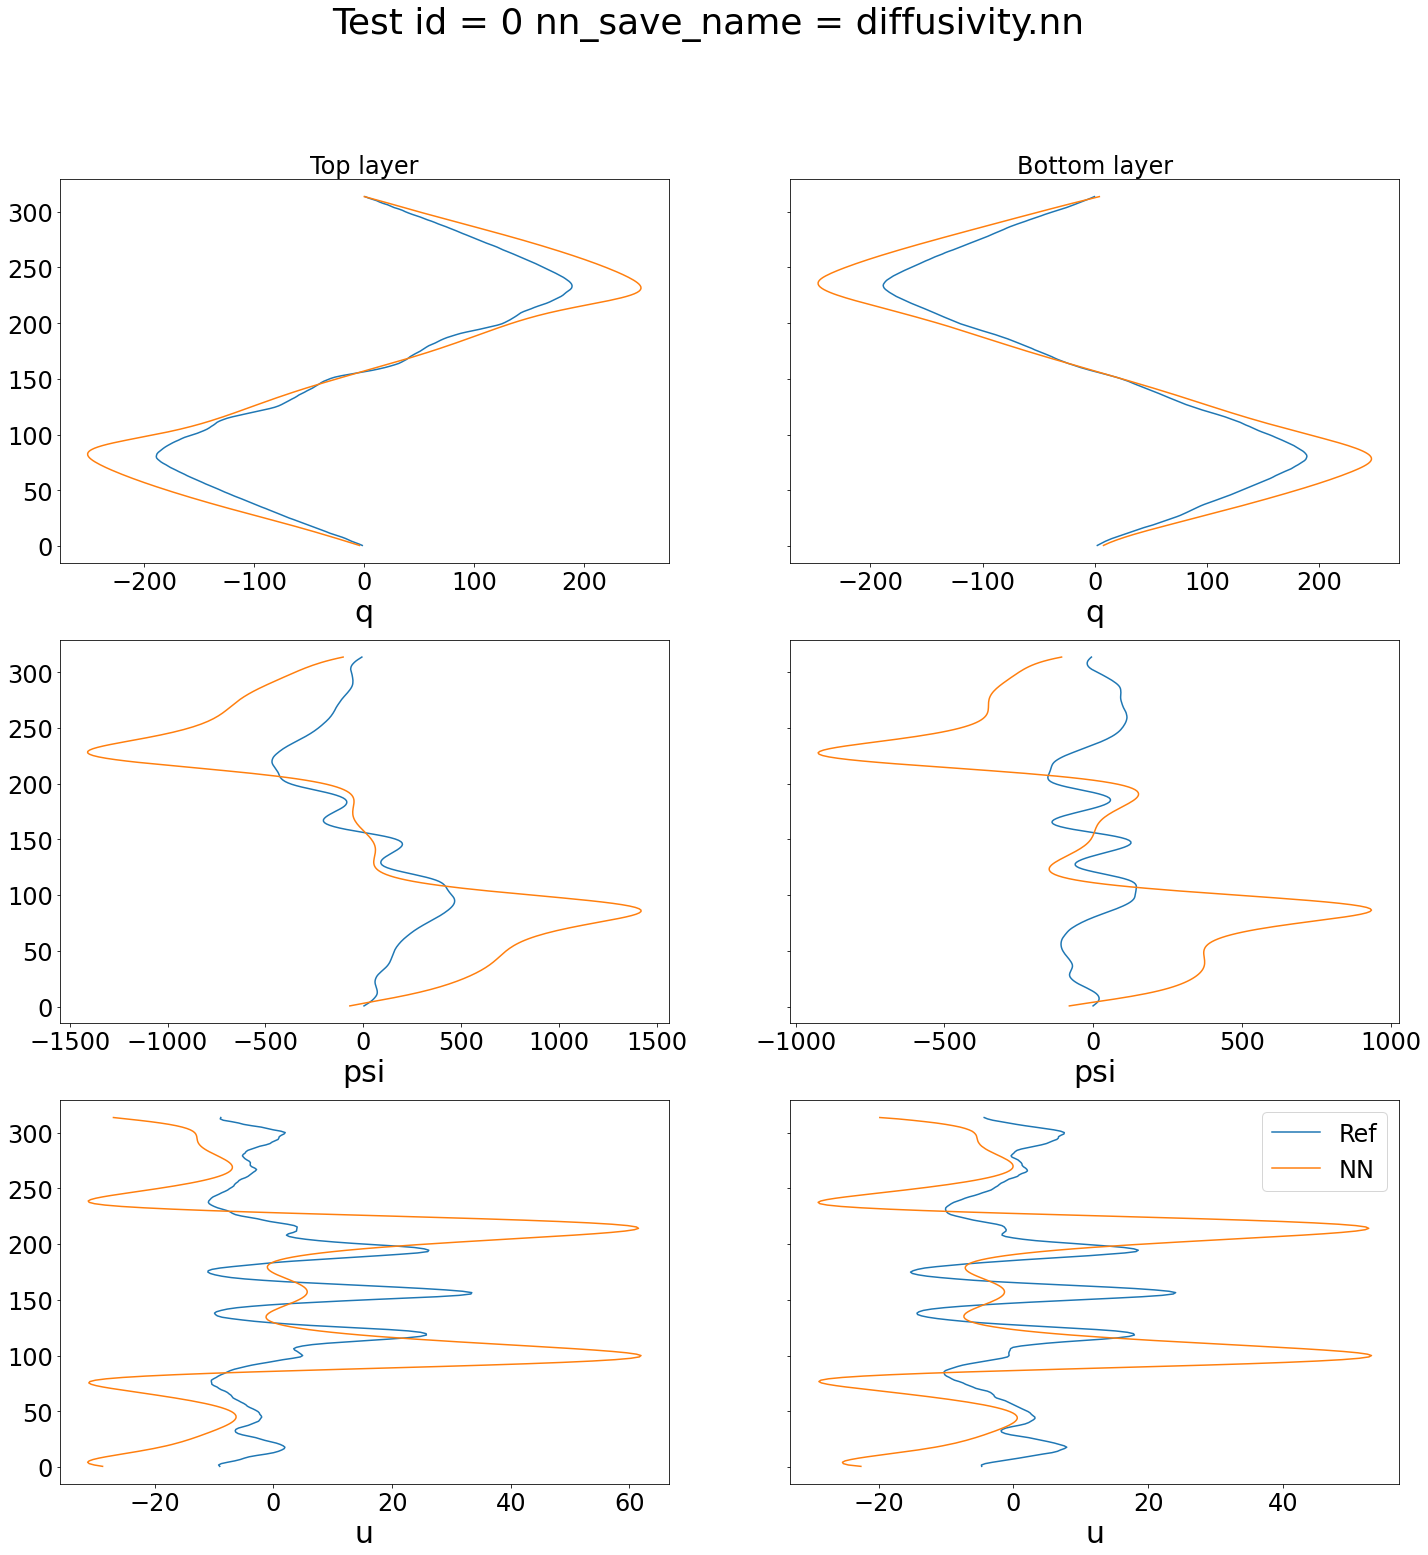

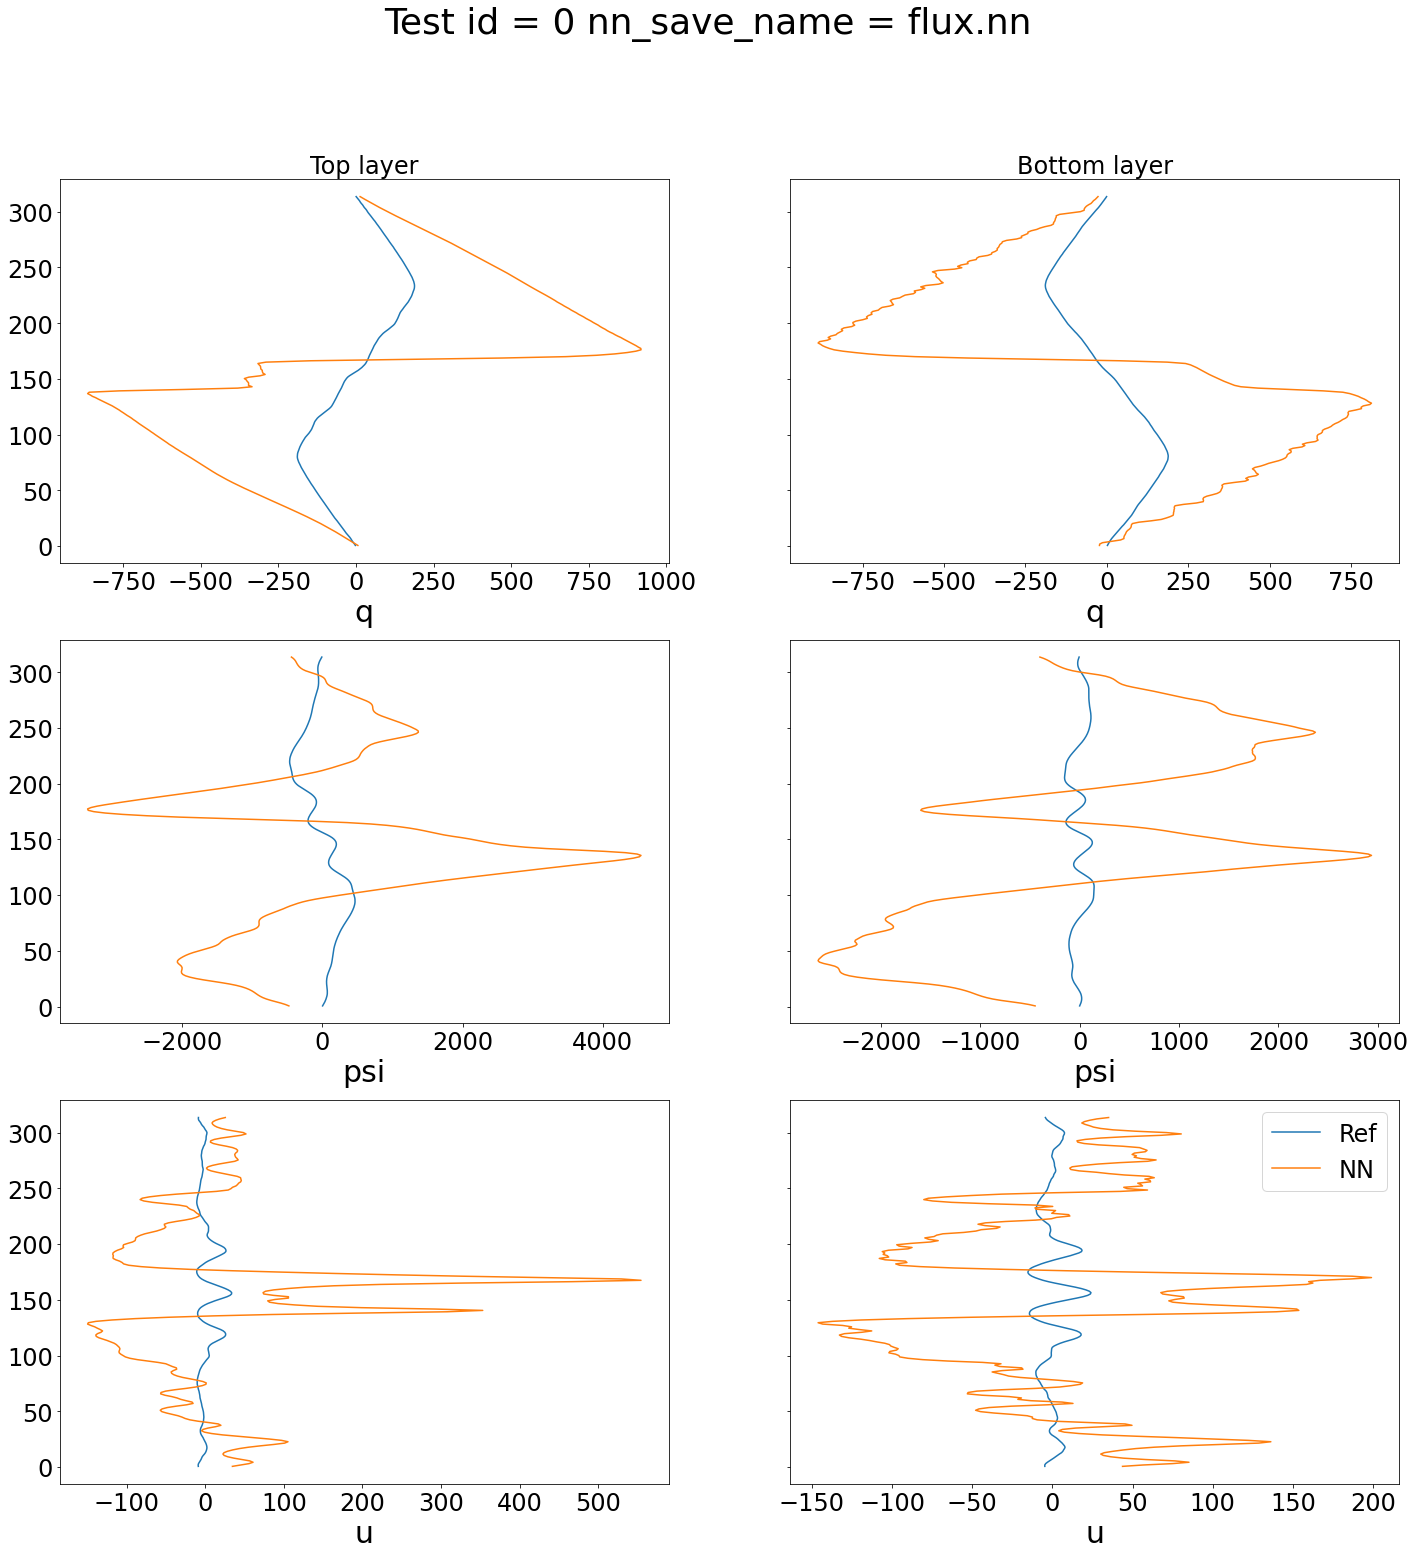

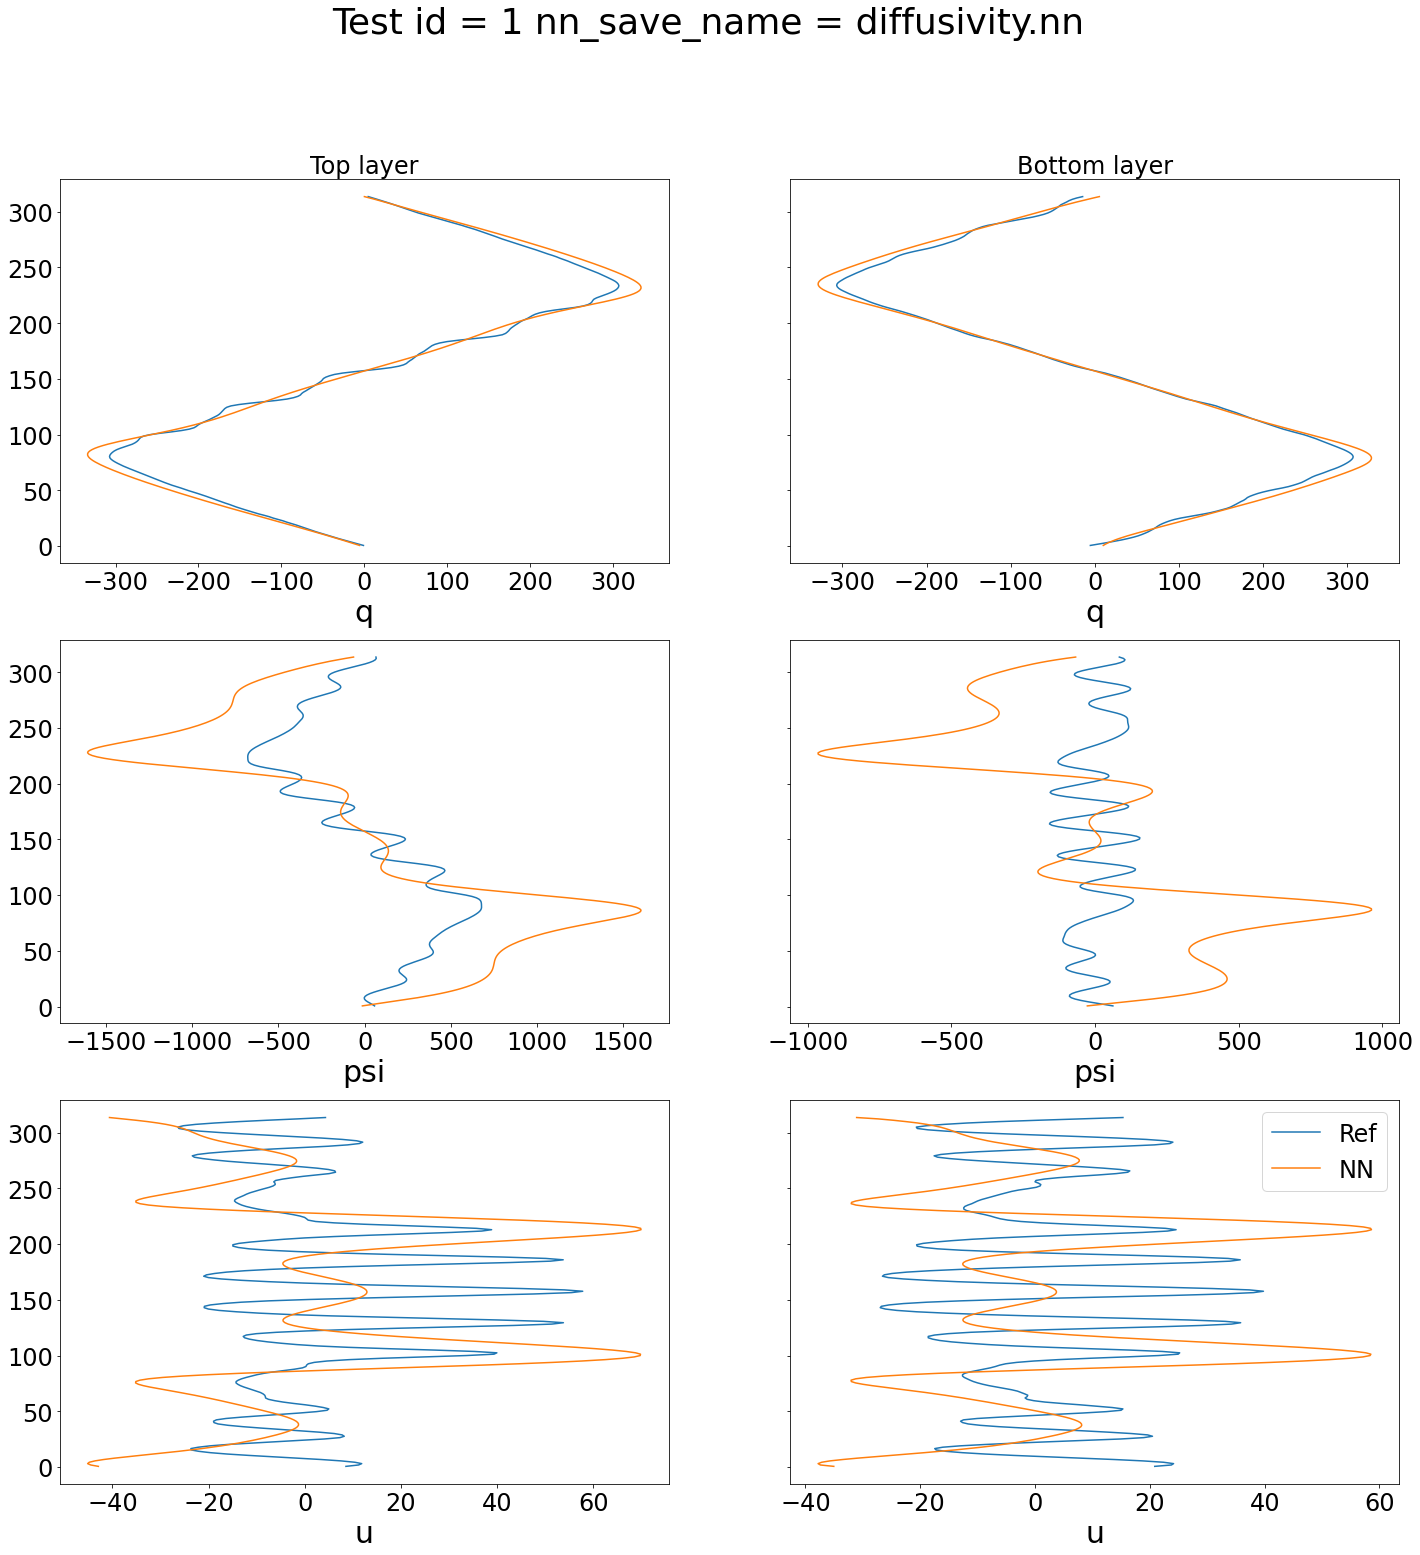

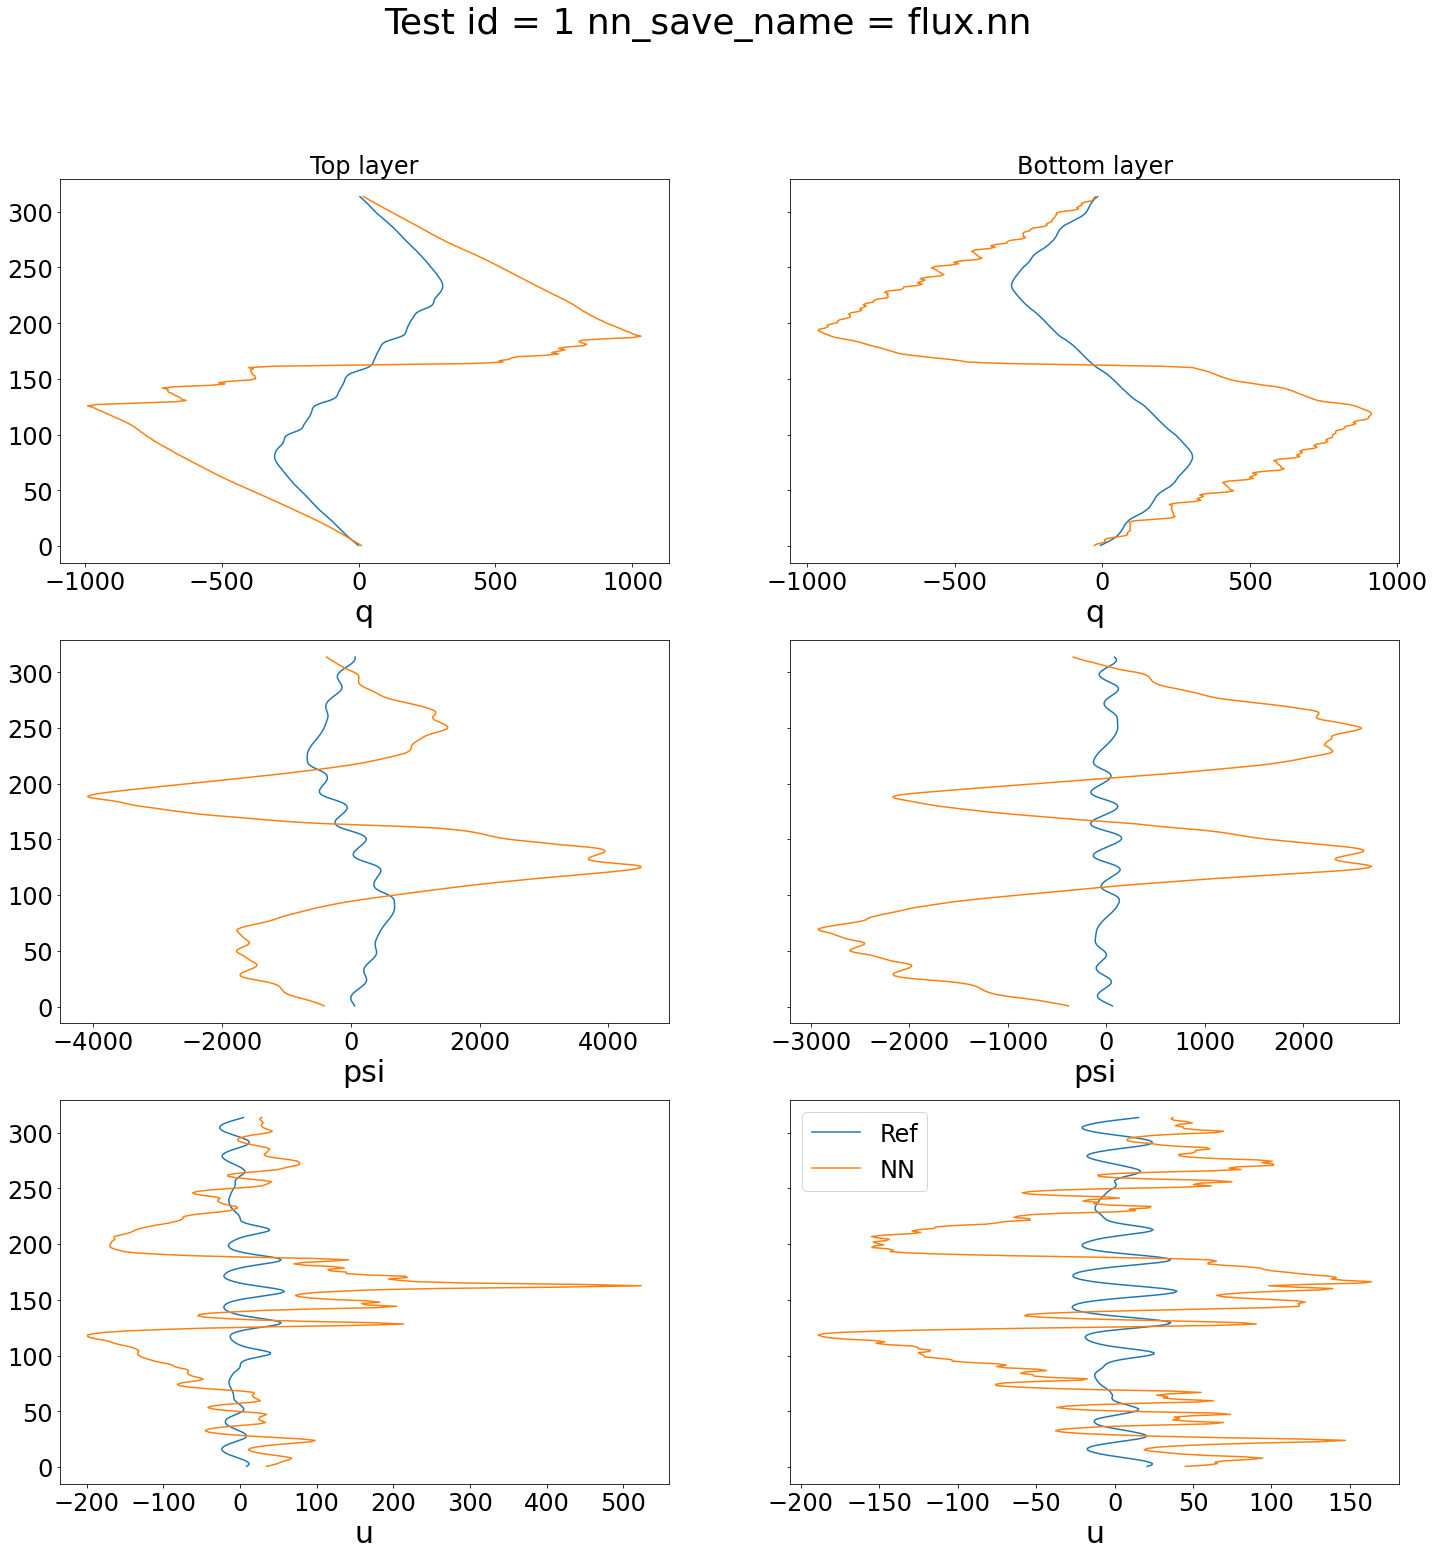

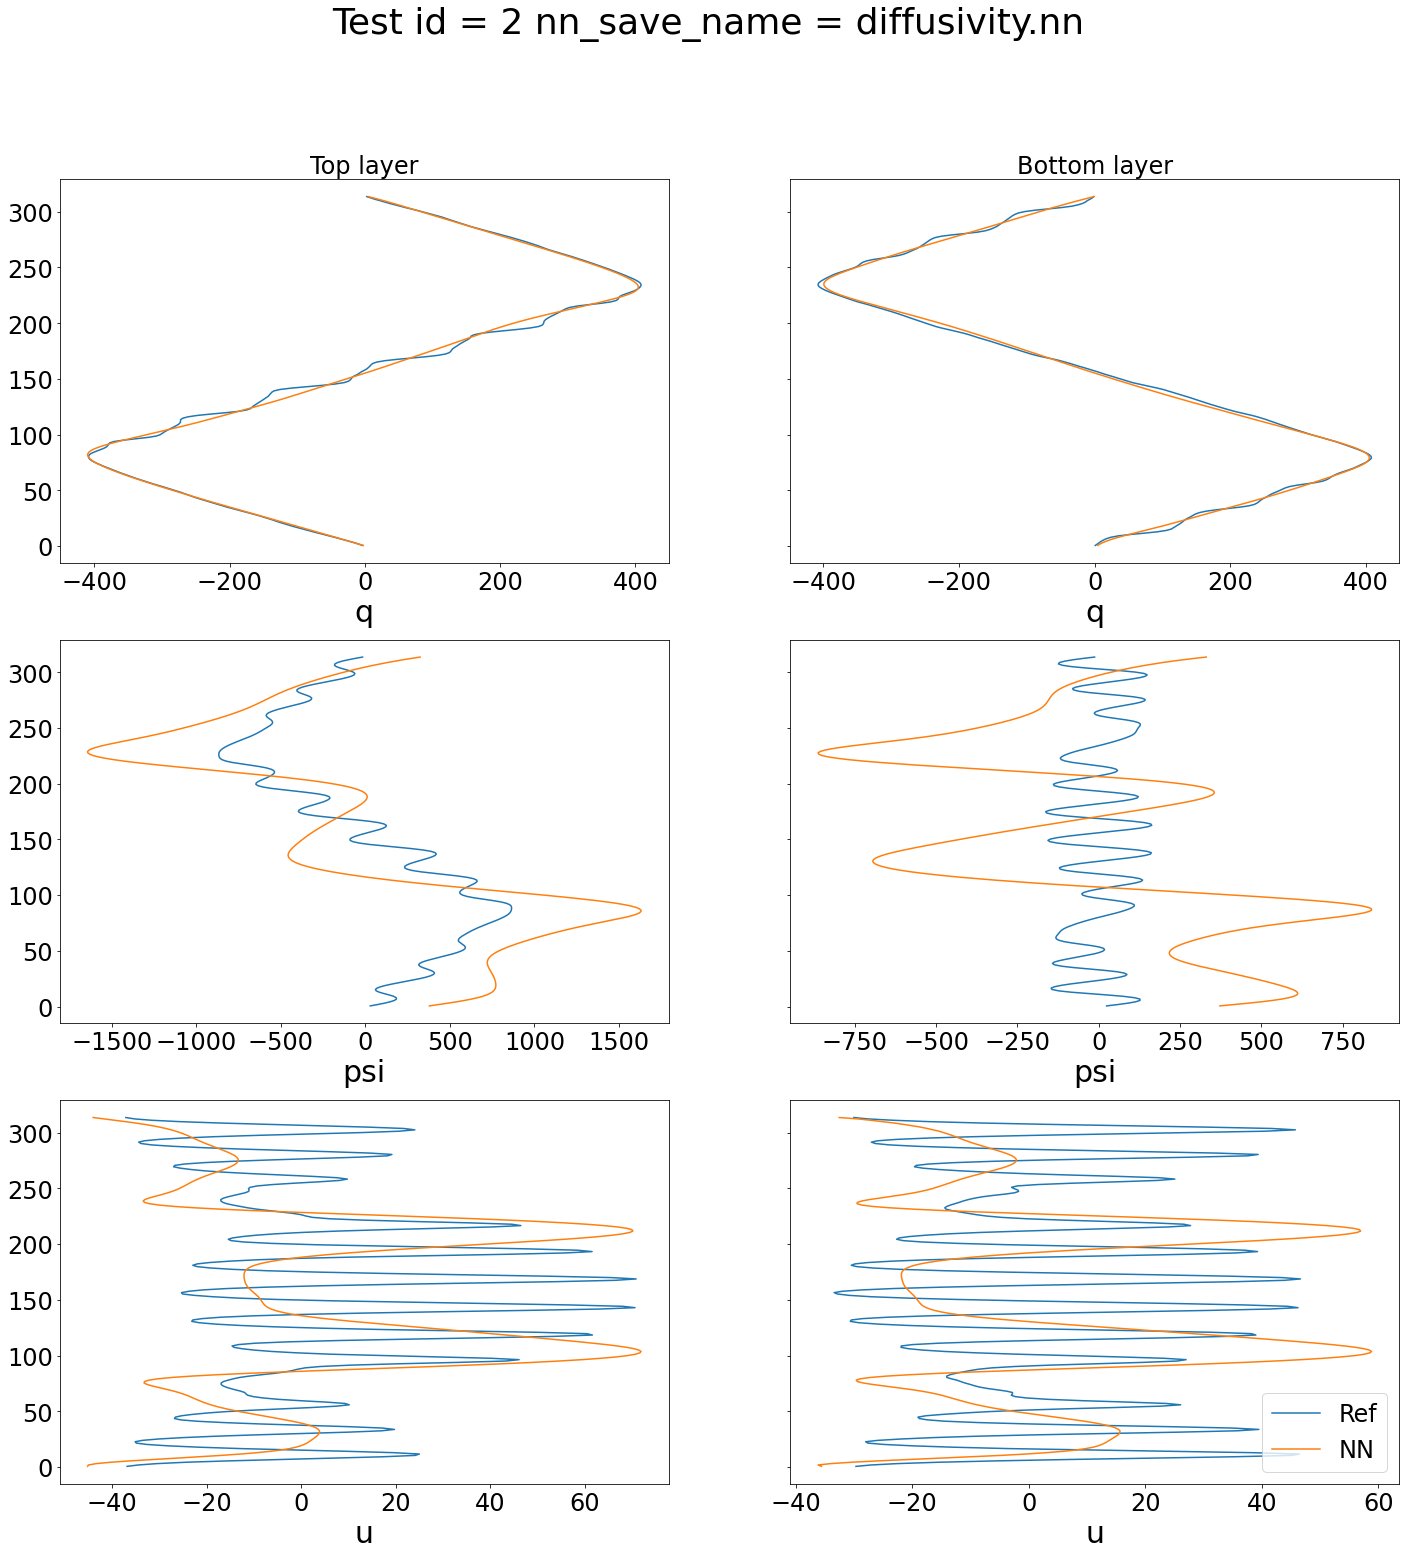

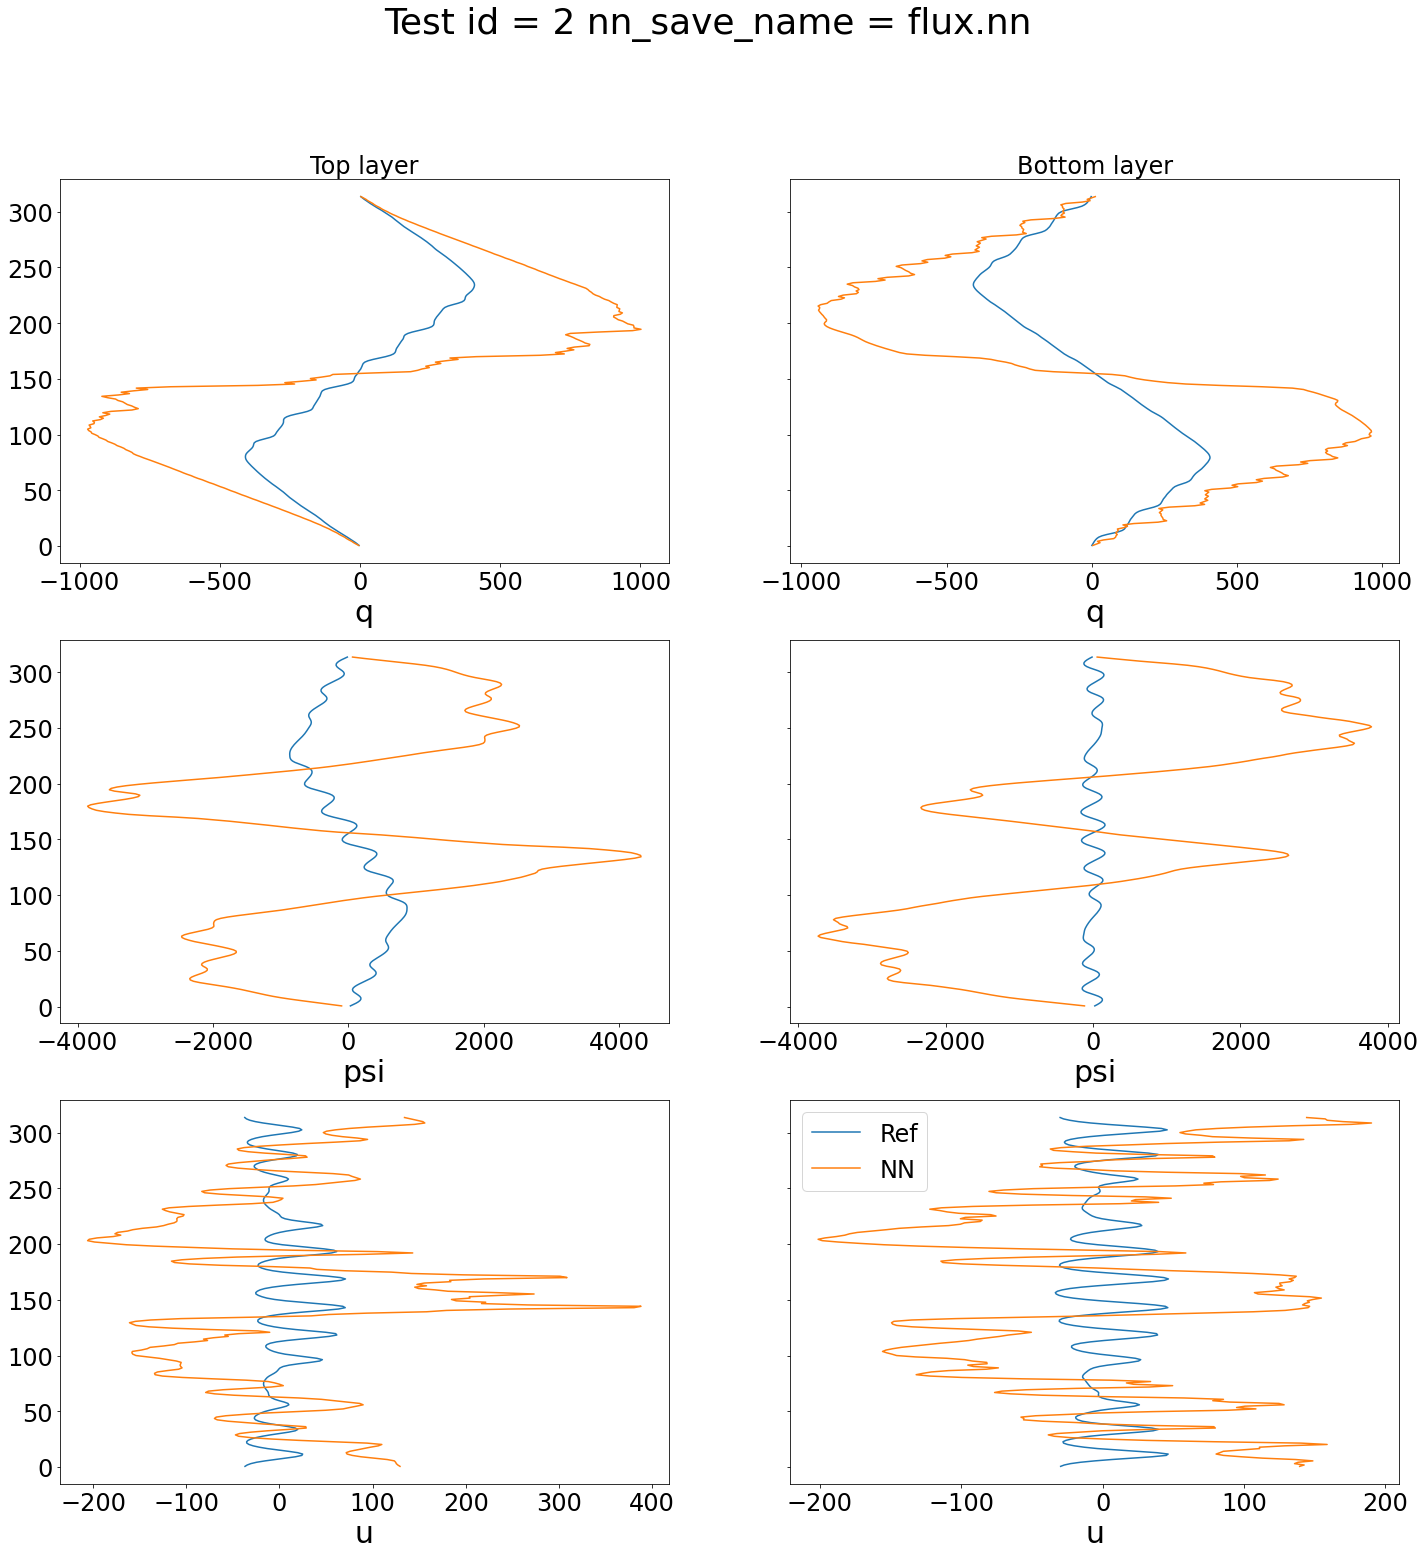

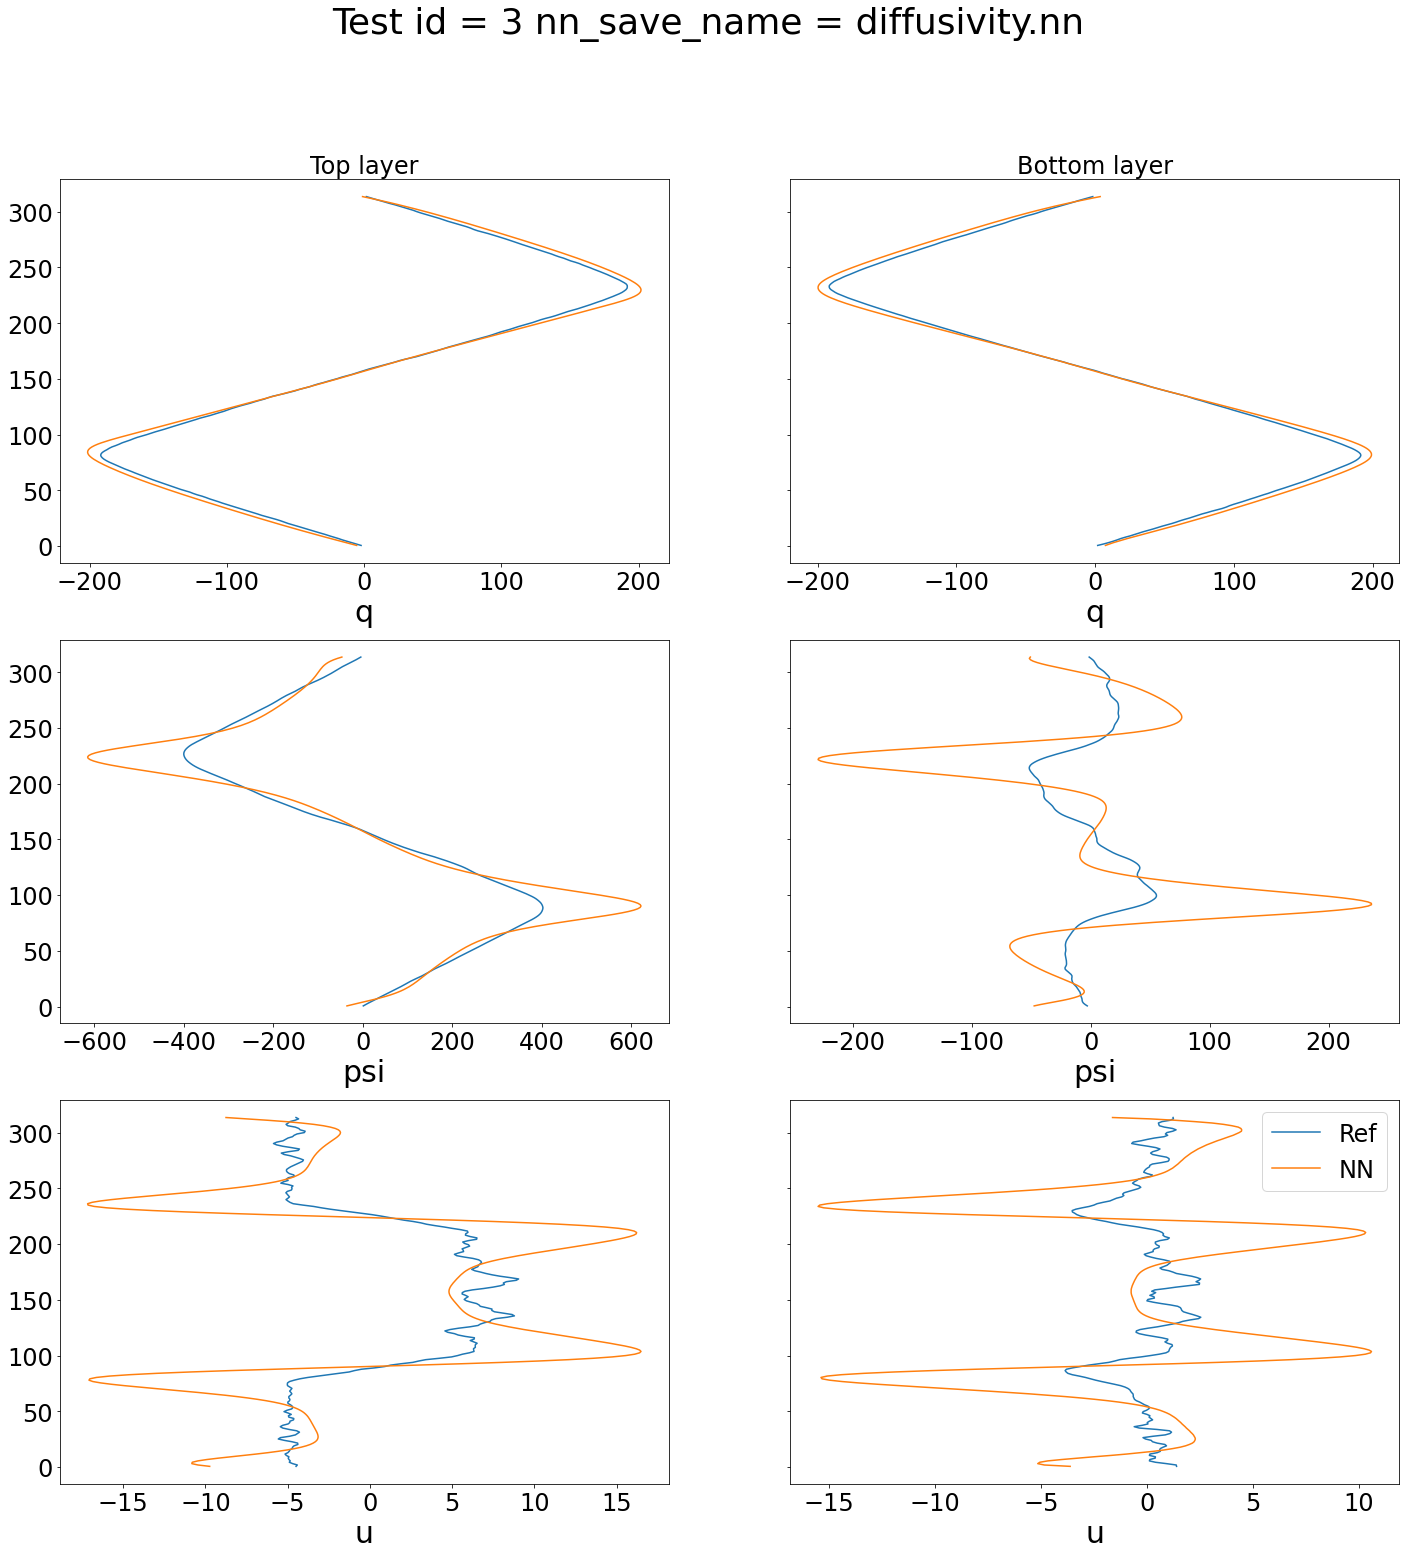

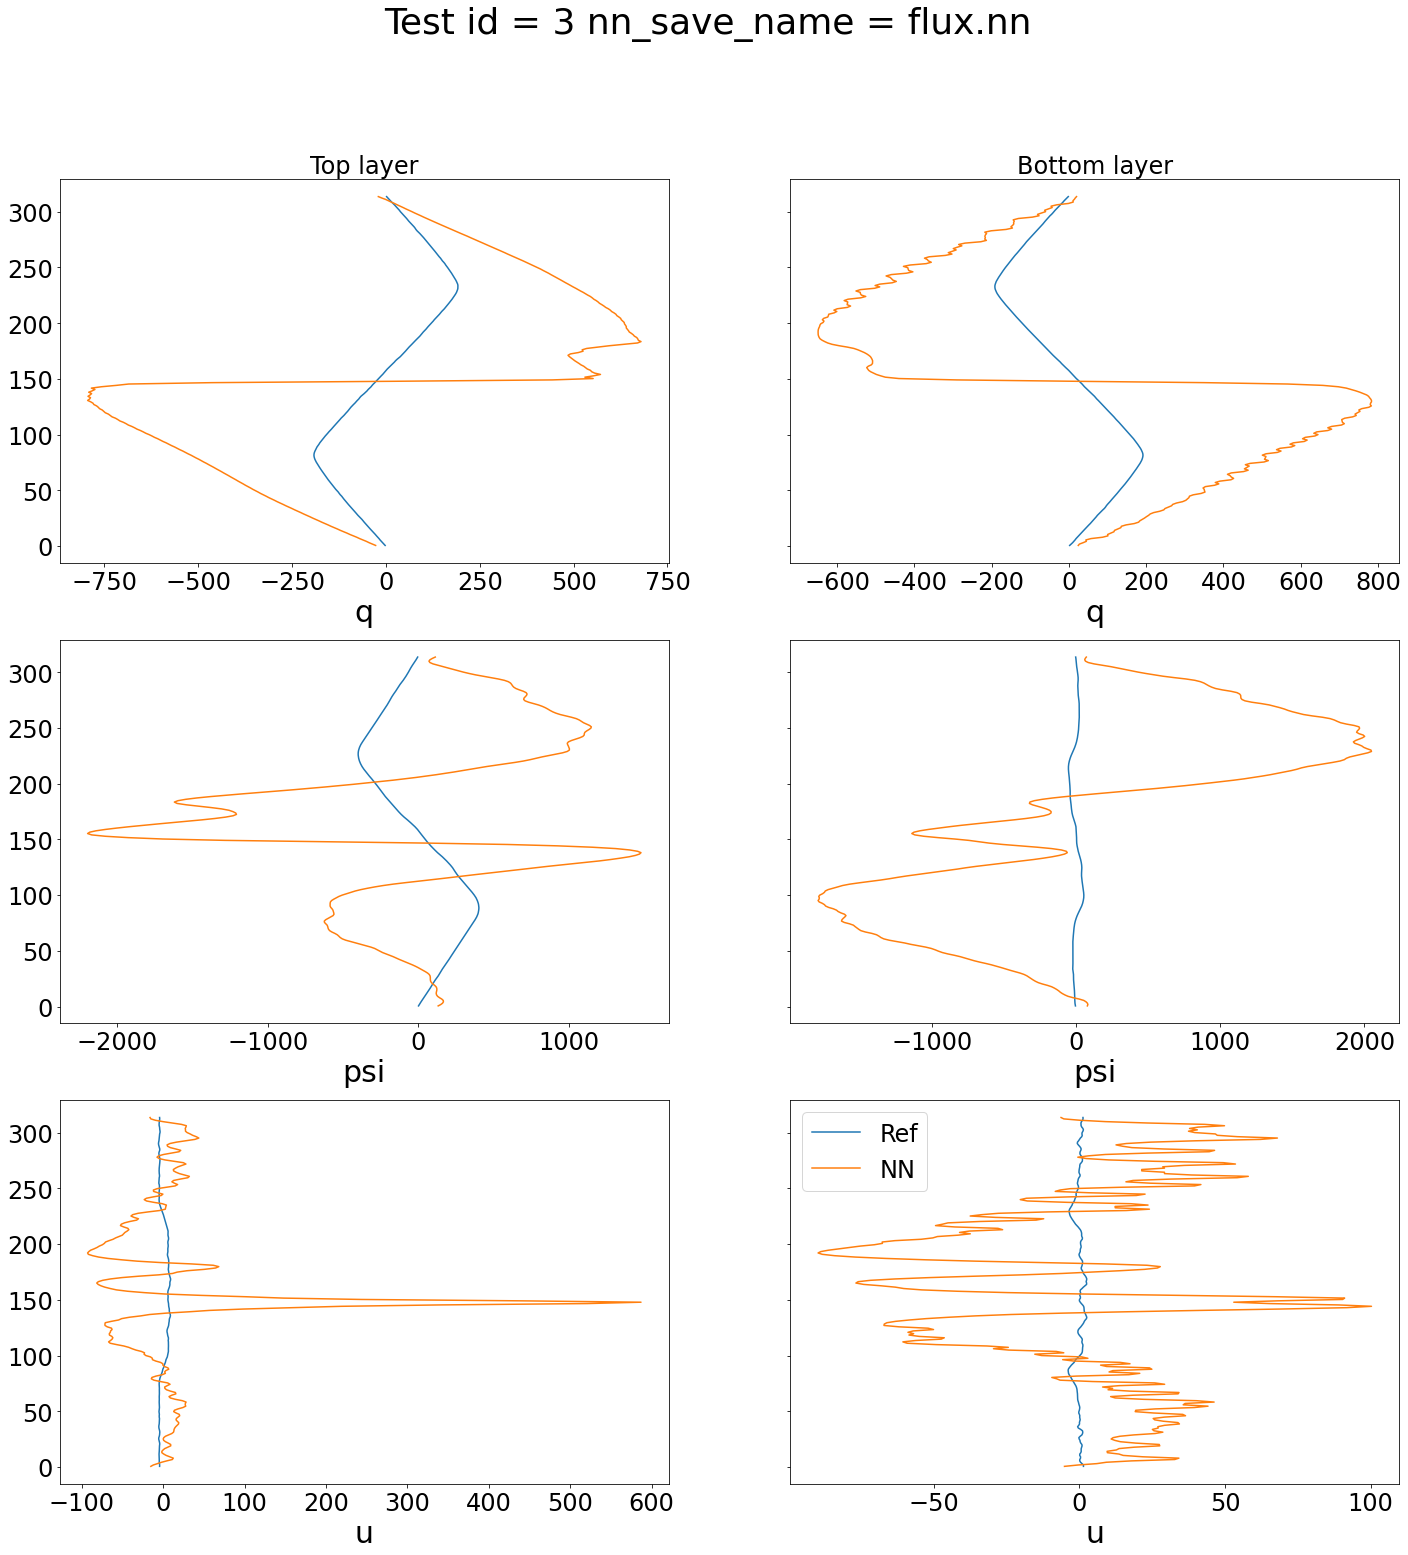

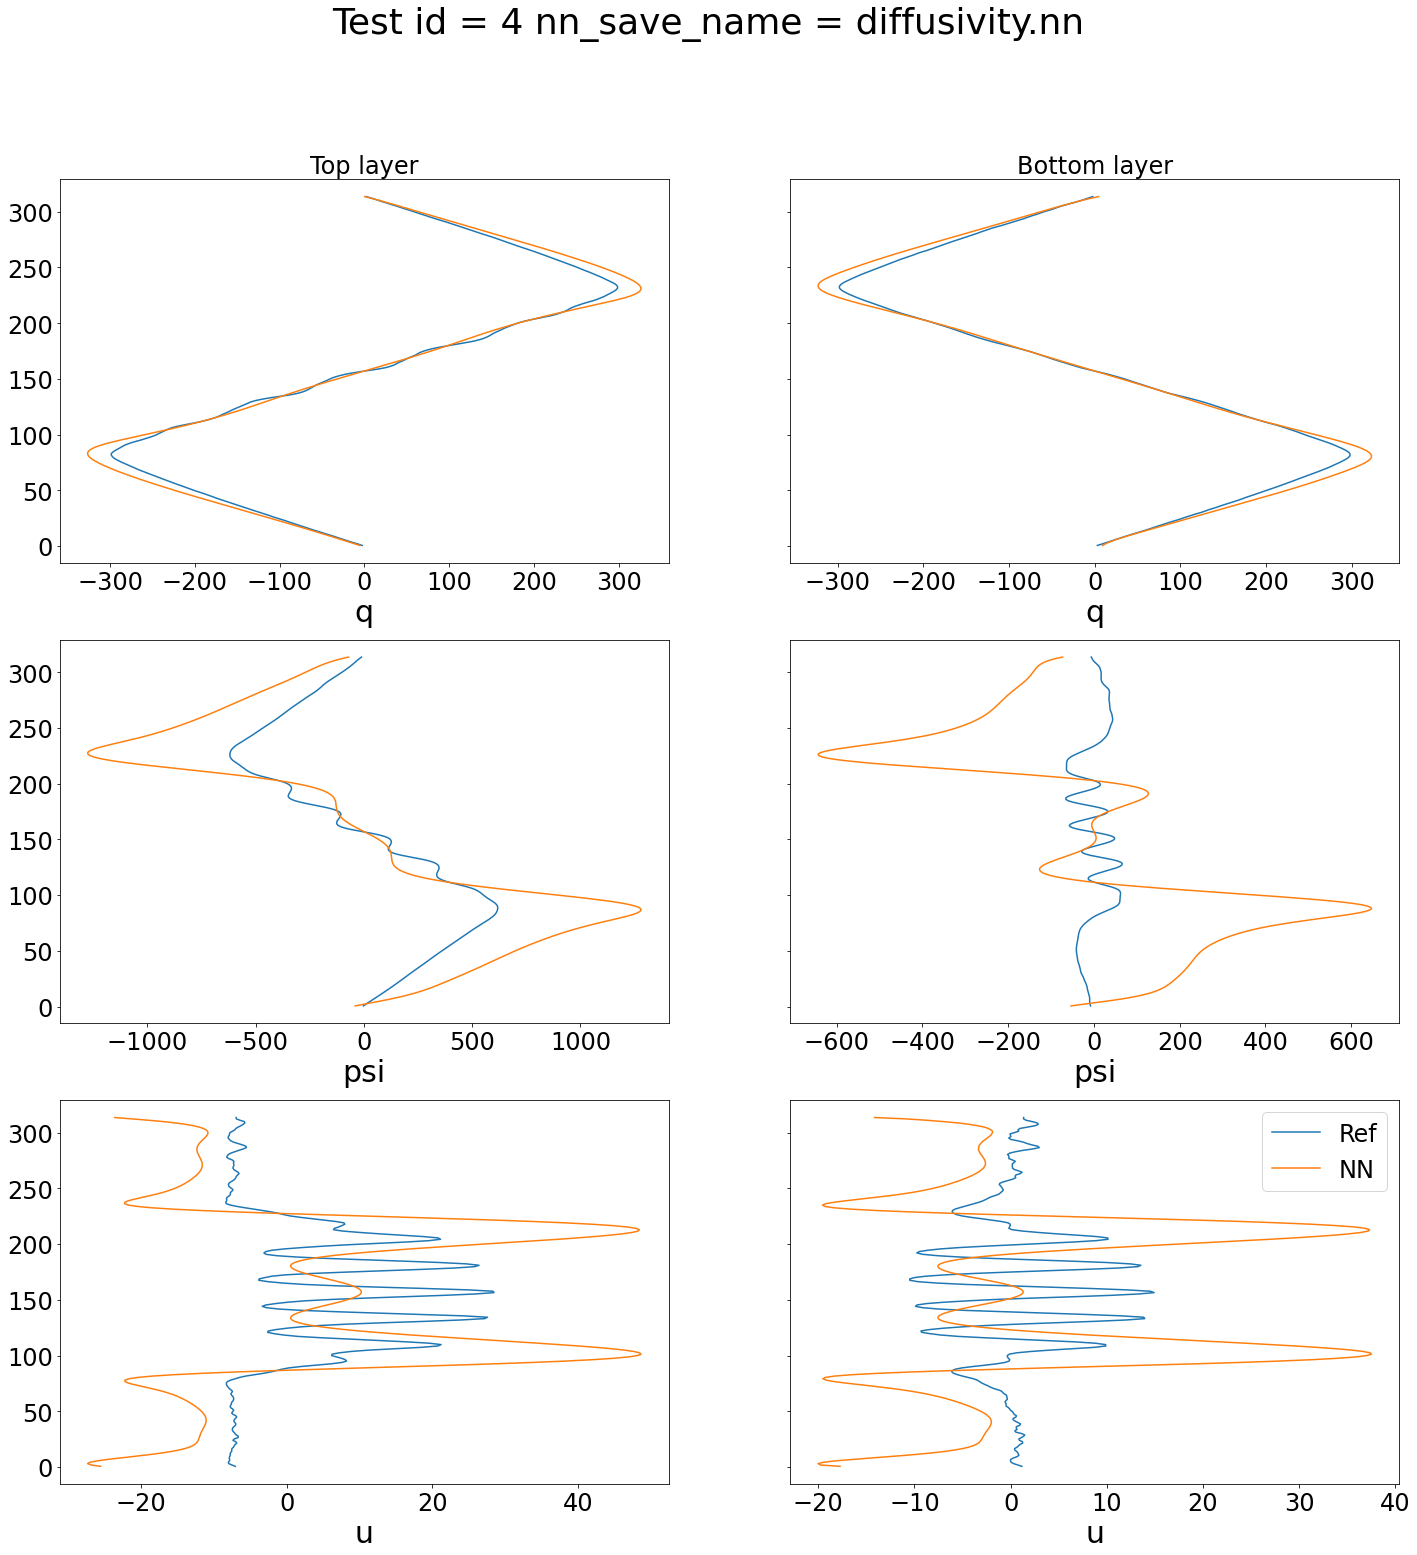

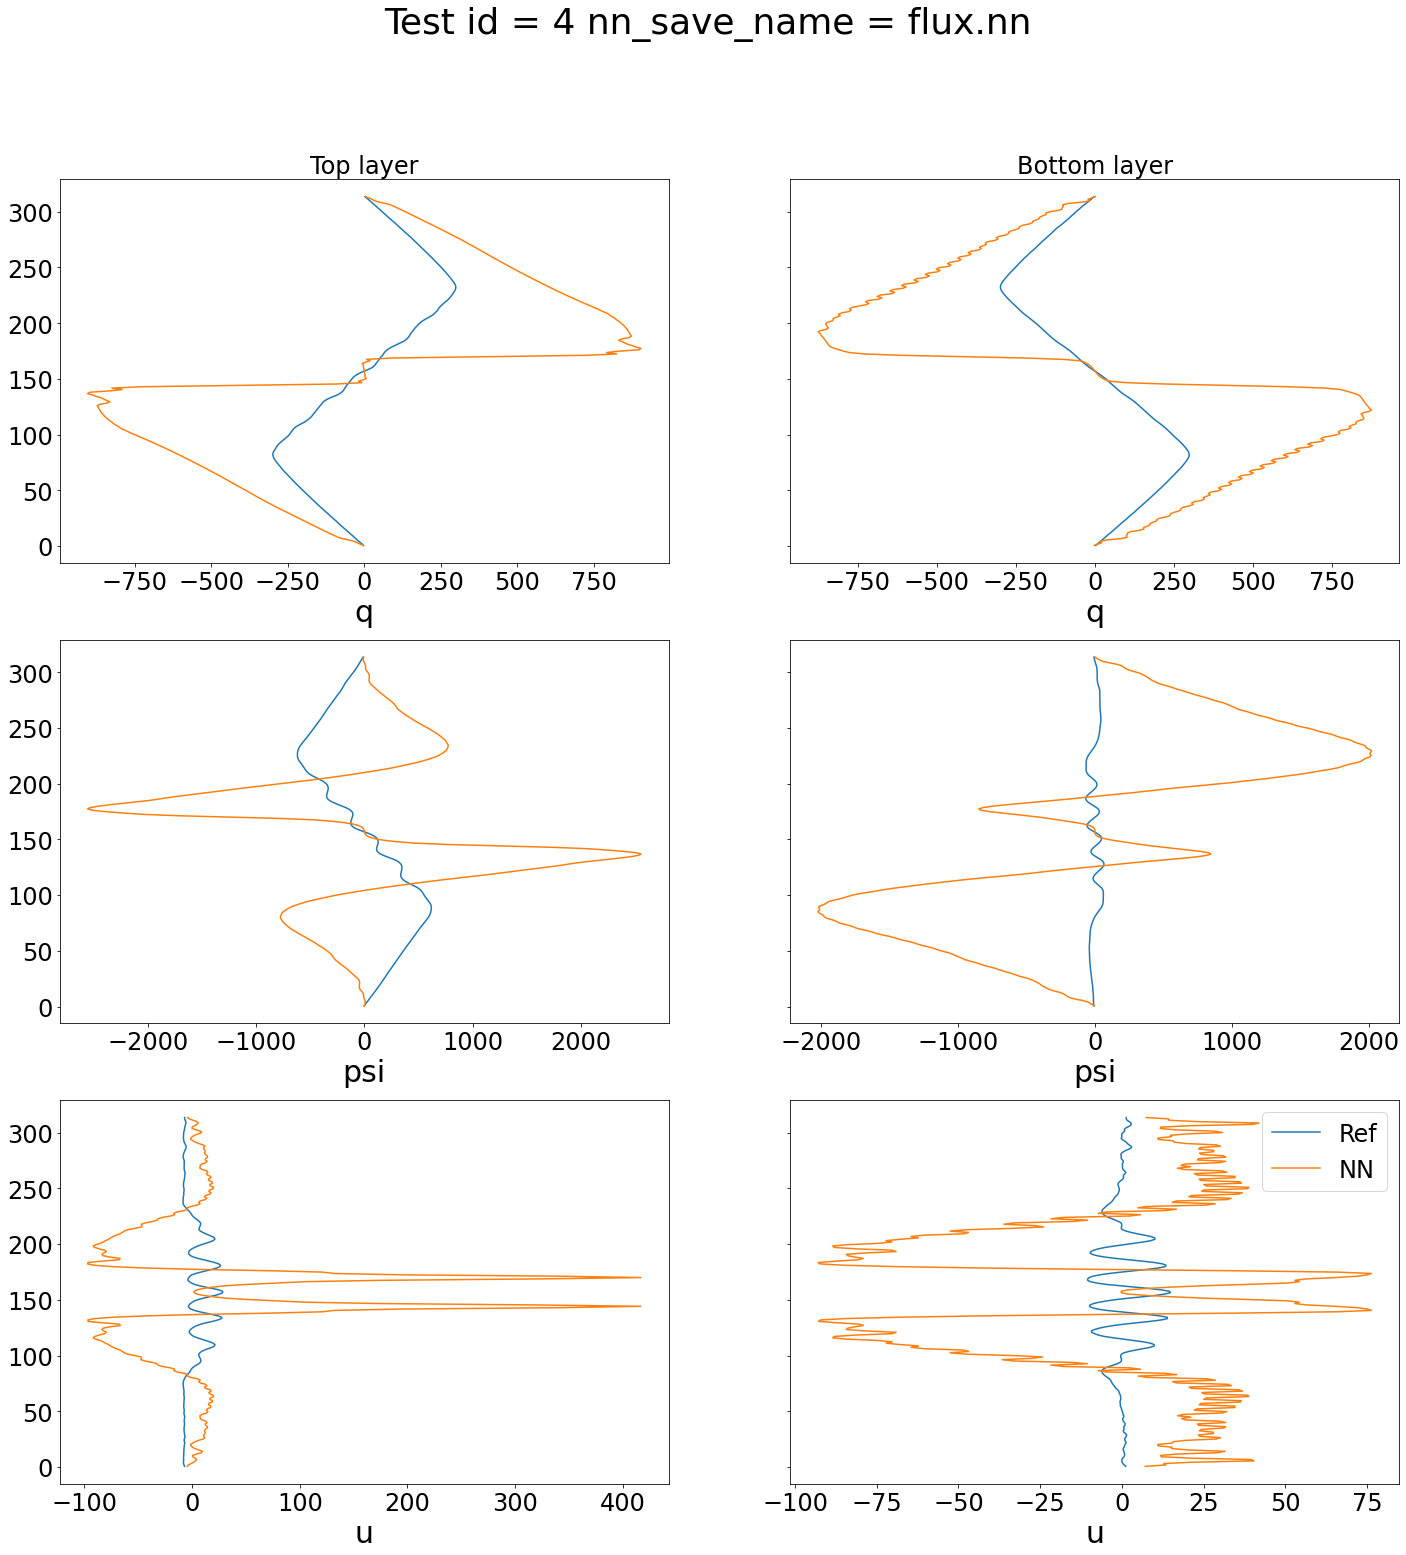

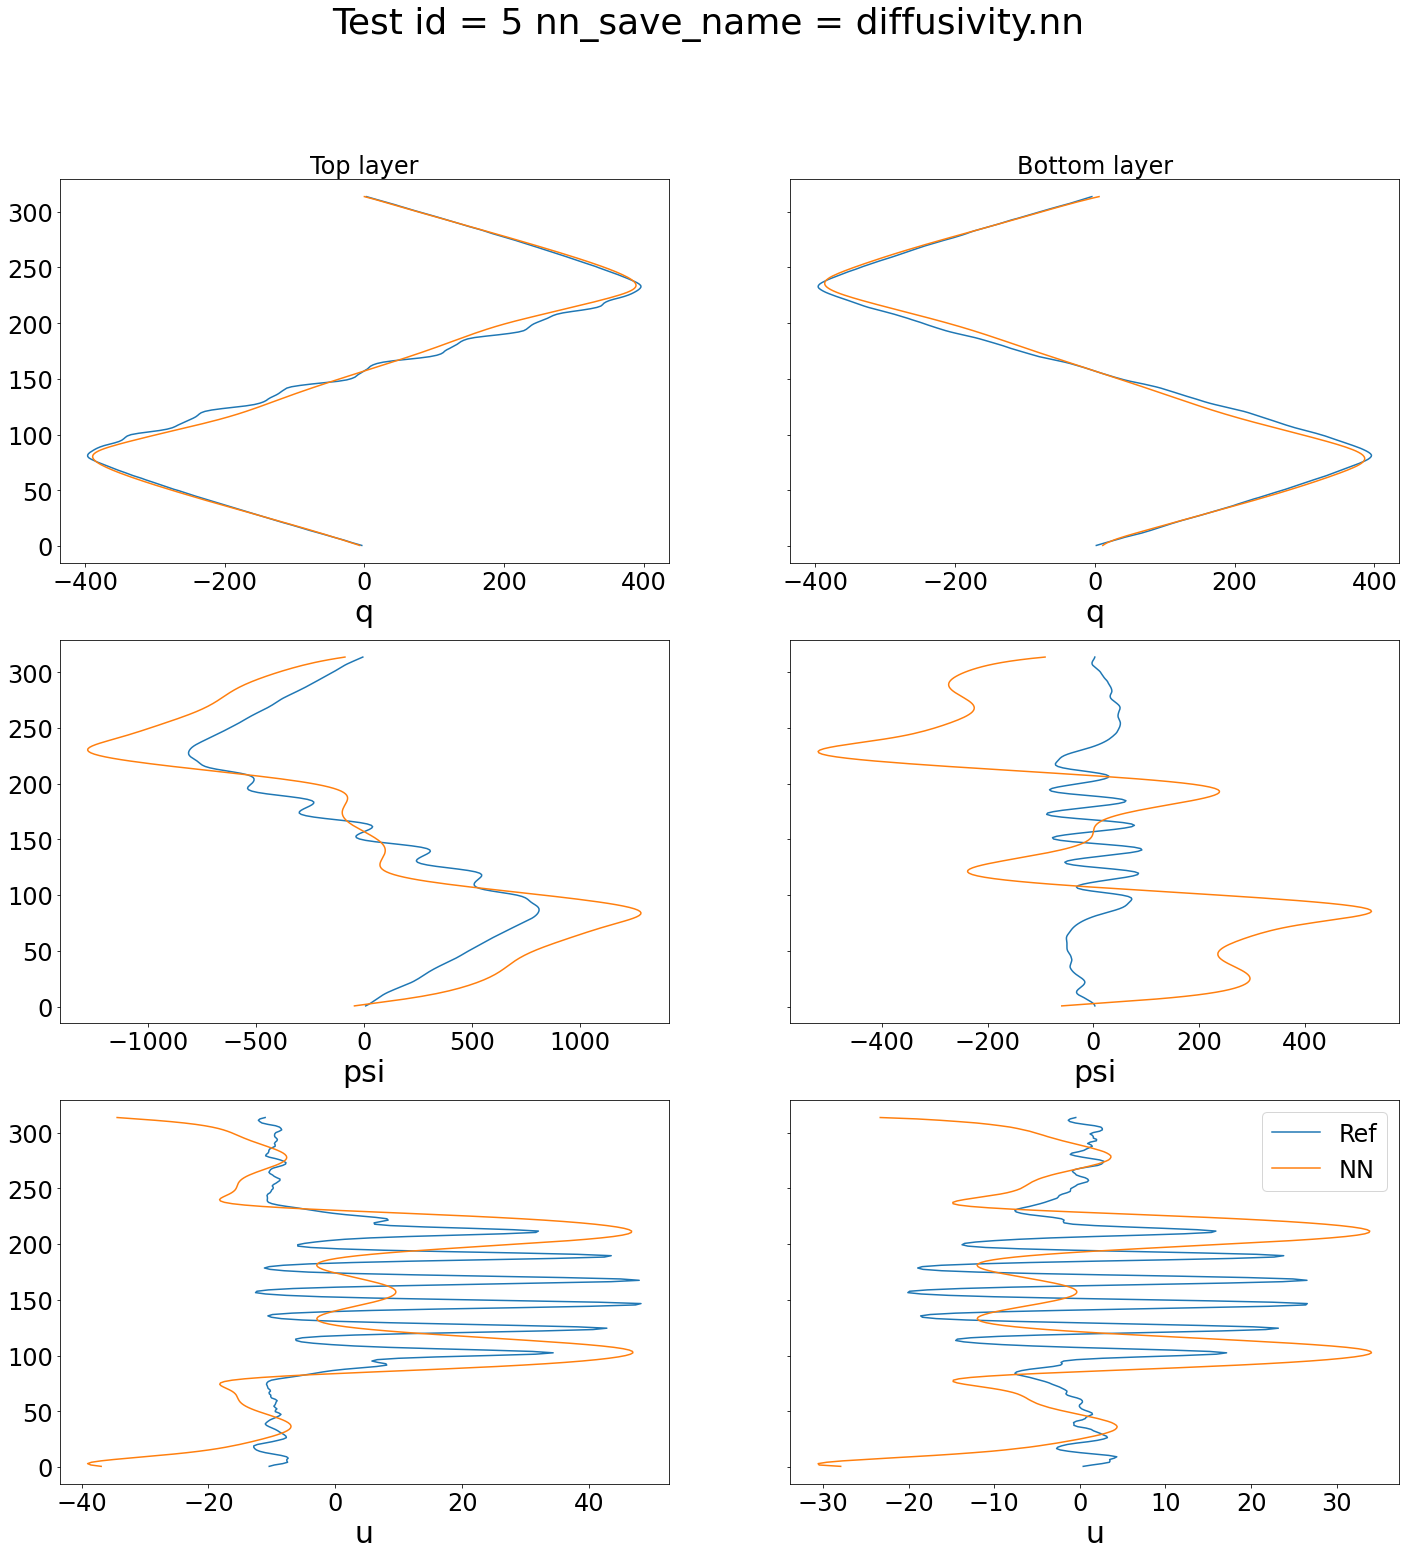

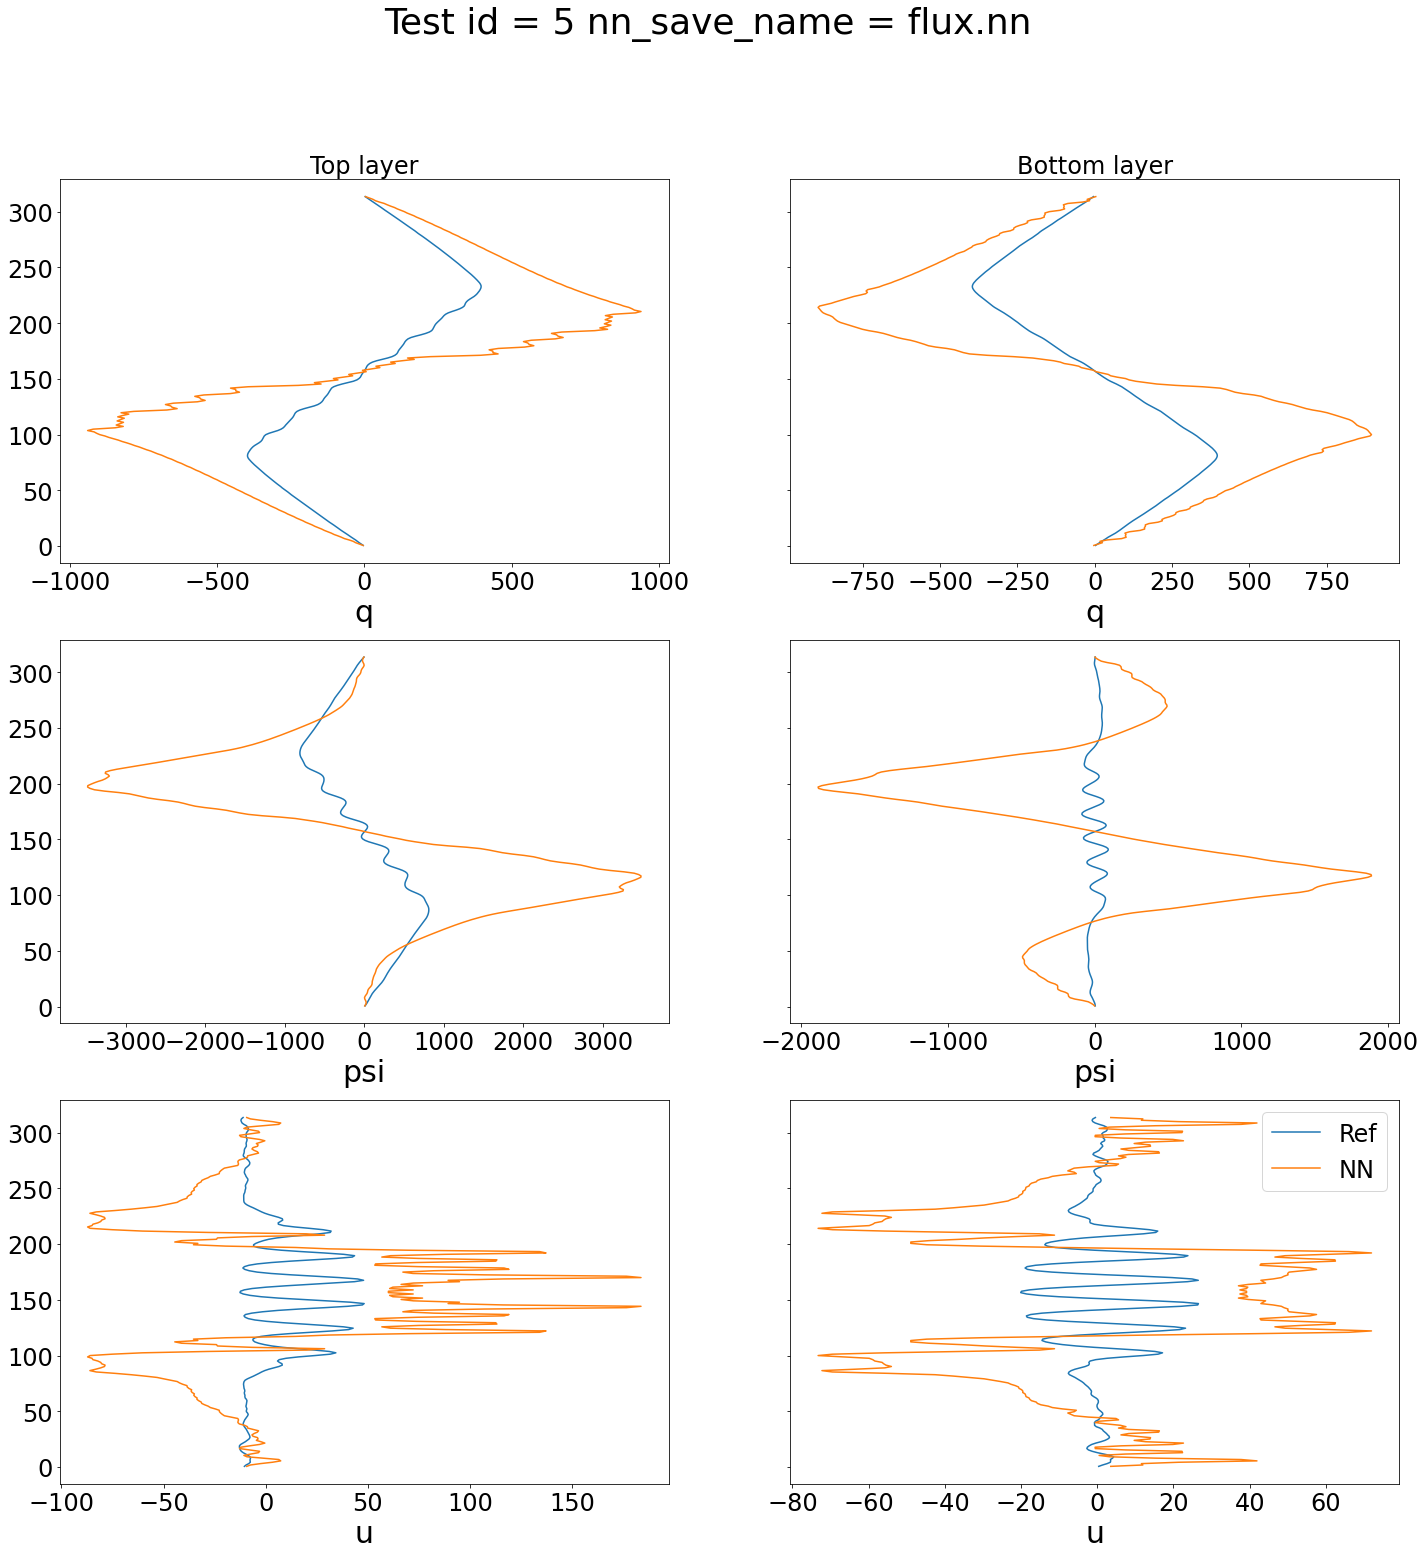

In [13]:
def Qg(params, nn_save_name, force):
    trained_net = torch.load(nn_save_name)
    dt = 4e-3
    save_every = 1000
    Nt = 400000 

    
    Ny = force.shape[1]
    
    # q0 = np.copy(q_mean)
    q0 = np.zeros((2, Ny))
    yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

    q0[0, :] = -params.beta*L/2 * np.sin(2*np.pi*yy/L)
    q0[1, :] =  params.beta*L/2* np.sin(2*np.pi*yy/L)
    
    beta1 = beta2 = params.beta
    
    
    if nn_save_name == "diffusivity.nn":
        nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
        model = lambda q, psi, xx, res, k2, dealiasing_filter : nummodel_fft(nn_model, beta1, beta2,  q, psi, xx, res, k2, dealiasing_filter)
    elif nn_save_name == "flux.nn":
        nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = flux_scale, non_negative=False, filter_on=False, filter_sigma=filter_sigma)
        model = lambda q, psi, xx, res, k2, dealiasing_filter : nummodel_flux_fft(nn_model, beta1, beta2,  q, psi, xx, res, k2, dealiasing_filter)
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
        
    yy, t_data, q_data = explicit_solve(model, force, q0, params, dt = dt, Nt = Nt, save_every = save_every)  
    q_mean_pred = np.mean(q_data[Nt//(2*save_every):, :, :], axis=0) 
    return yy, q_mean_pred, q_data 

Ny = 256
L = 50*2*np.pi
H = [1.0, 1.0]               # the rest depths of each layer
kd = 1.0                     # rd

U = [0.0, 0.0]
dU = U[0] - U[1] 
F1 = kd/(1 + (H[0]/H[1])**2.0)
F2 = kd/(1 + (H[1]/H[0])**2.0)
hyper_nu, hyper_order = 0.0, 2
Q = 1.0
yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

force = np.zeros((2, Ny))
force[0, :] = -Q * np.sin(2*np.pi*yy/L)
force[1, :] =  Q * np.sin(2*np.pi*yy/L)   
    
for test_ind in range(N_data):
    for nn_save_name in ["diffusivity.nn", "flux.nn"]:
        q_mean_ref = q_mean[test_ind, :, :]
        dpv_mean_ref = dpv_mean[test_ind, :, :]
        params = QG_params(L=L, dU=dU, F1=F1, F2=F2, hyper_nu=hyper_nu, hyper_order=hyper_order, beta=beta_reks[test_ind][0], rek=beta_reks[test_ind][1])
        yy, q_mean_pred, q_data  = Qg( params , nn_save_name, force)
    

        fig, ax = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=True, figsize=(24,24))
        ax[0,0].plot(q_mean_ref[0, : ], yy,   label="Ref")                                                                         
        ax[0,0].plot(q_mean_pred[0, : ], yy, label="NN")
        ax[0,1].plot(q_mean_ref[1, : ] , yy,   label="Ref")                                                                         
        ax[0,1].plot(q_mean_pred[1, : ], yy, label="NN")
        ax[0,0].set_xlabel("q")
        ax[0,1].set_xlabel("q")


        # compute psi
        k2, dealiasing_filter = precomp_fft(Ny)
        psi_mean_ref = psi_mean[test_ind, :, :] # psi_fft_sol(q_mean_ref, F1, F2, dy, k2, dealiasing_filter)
        psi_mean_pred = psi_fft_sol(q_mean_pred, F1, F2, dy, k2, dealiasing_filter)

        ax[1,0].plot(psi_mean_ref[0, : ], yy,   label="Ref")                                                                         
        ax[1,0].plot(psi_mean_pred[0, : ], yy, label="NN")
        ax[1,1].plot(psi_mean_ref[1, : ] , yy,   label="Ref")                                                                         
        ax[1,1].plot(psi_mean_pred[1, : ], yy, label="NN")
        ax[1,0].set_xlabel("psi")
        ax[1,1].set_xlabel("psi")


        # compute U velocity
        k2, dealiasing_filter = precomp_fft(Ny)
        u_mean_ref = np.copy(psi_mean_ref)
        u_mean_pred = np.copy(psi_mean_pred)
        for i in range(2):
            u_mean_ref[i,:] = -gradient_fft(psi_mean_ref[i,:], dy, 1, k2, dealiasing_filter)
            u_mean_pred[i,:] = -gradient_fft(psi_mean_pred[i,:], dy, 1, k2, dealiasing_filter)

        ax[2,0].plot(u_mean_ref[0, : ], yy,   label="Ref")                                                                         
        ax[2,0].plot(u_mean_pred[0, : ], yy, label="NN")
        ax[2,1].plot(u_mean_ref[1, : ] , yy,   label="Ref")                                                                         
        ax[2,1].plot(u_mean_pred[1, : ], yy, label="NN")
        ax[2,0].set_xlabel("u")
        ax[2,1].set_xlabel("u")


        ax[0,0].set_title("Top layer")
        ax[0,1].set_title("Bottom layer")
        
        fig.suptitle("Test id = "+str(test_ind)+" nn_save_name = "+str(nn_save_name))
        plt.legend()